In [6752]:
import numpy as np
import matplotlib.pyplot as plt

define constants

In [6753]:
sample_rate = 1e6 
N = 1000 # number of observations
d= 0.5 # Half Wavelengh 
Nr = 8# Number of sensors
t = np.arange(N)/sample_rate # time vector

defenition of  signal w/ given doa, aml-e, and freq

In [6754]:
def create_signal(theta_deg, amplitude, f_tone):
    x = (amplitude)*np.exp(2j * np.pi * f_tone * t)
    s = np.exp(-2j * np.pi * d * np.arange (Nr) * np.sin(theta_deg/180*np.pi))
    s = s.reshape(-1, 1) #column vector
    x = x.reshape(1, -1) #row vector
    X = s @ x #create steered signal X (N x Nr)
    return X

Below our "stimulus" is created

In [6755]:
f_tone = 0.02e6 #tone frequency
tx = 1*np.exp(2j * np.pi * f_tone * t)
tx2 = 2*np.exp(2j * np.pi * f_tone*2 * t)
theta_deg = 50 # direction of arrival 
theta_deg2 = 2 # direction of arrival 
theta_deg3 = -10 # direction of arrival 
X1 = create_signal(theta_deg, 1, 0.12e6 )
X2 = create_signal(theta_deg2,1, 0.52e6 )
X3 = create_signal(theta_deg3, 1, 0.32e6 )

n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)

X = X1 +X2 + 0.0003*n  # X and n are both NrxN
Xsum = np.sum(X, 0)/Nr
print(Xsum.shape) # 3x10000.  X is now going to be a 2D array, 1D is time and 1D is the spatial dimension

(1000,)


Visualising...

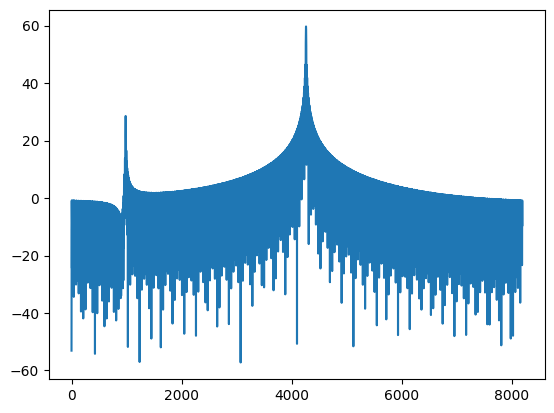

In [6756]:
plt.plot(10*np.log10(np.abs(np.fft.fft(Xsum, 8192))**2))
plt.show()

1. Initalize algorithm with:
    
    $P(0) = {1 \over \sigma_o^2}I$, I is Identity matrix

    $w(0) = v_s/N$ , 
    
    or $w(0) = w_q$

2. At each snapshot $K = 1, 2, ...$ update 

    $g(K) = {\mu^{-1} P(K-1) X(K) \over 1+ \mu^{-1} X^H(K) P(K-1) X(K)} $ , and

    $P(K) = \mu^{-1}P(K-1) - \mu^{-1} g(K) X^H(K) P(K-1)$

3. Compute $e_p = D(K) - w_{lse}(K-1) X(K)$, in other words error value
4. Compute $w_{lse}(K) =  w_{lse}(K-1) + g(K) e_p^*$, * is complex conjugate


In [6757]:
def lse_rls(mu, sigma_o_square, X, D):
    mu_inv = 1/mu
    P = (1/sigma_o_square)*np.eye(Nr) #P(0)
    wq = np.ones(Nr) # w(0)
    w_lse = wq
    Pk = P
    ekv =[]
    XX = X.T
    for k in range(len(X[0])):
        Xk = XX[k]
        gk = (mu_inv * Pk @ Xk) / (1 + mu_inv * Xk.conj().T @ Pk @ Xk)
        Pk = mu_inv * Pk - mu_inv * gk @ Xk.conj().T * Pk
        ek = D - w_lse.conj().T @ Xk
        w_lse = w_lse + gk * ek.conj()
        ekv = np.append(ekv, ek)
    ##end for##
    return w_lse, ekv


perform RLS implementation of LSE algorithm

In [6758]:
d = 0
mu = 0.9
sigma_o_sqr = 1


w_lse, ev = lse_rls(mu, sigma_o_sqr, X, d)
w = w_lse.reshape(1, -1)
w = w.conj()
print(w)


[[ 0.06860116+0.31472952j  0.12200722+0.27809507j -0.00948749+0.1850022j
   0.05185447-0.00100086j  0.05198075+0.00094325j -0.00912362-0.18512611j
   0.12130797-0.27813113j  0.06847851-0.31471096j]]


plot error vector

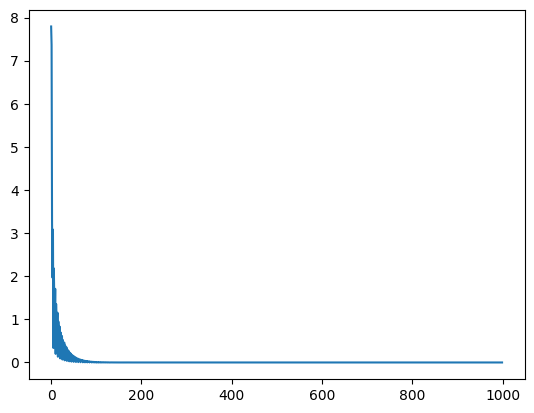

In [6759]:

plt.plot(np.abs(ev))
plt.show()


polar coordinates plot

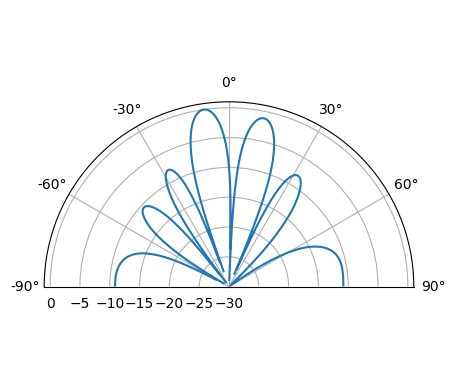

In [6760]:
N_fft = 512

w_padded = np.concatenate((w[0], np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak

# Map the FFT bins to angles in radians
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # in radians

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
ax.set_ylim([-30, 1]) # because there's no noise, only go down 30 dB

plt.show()

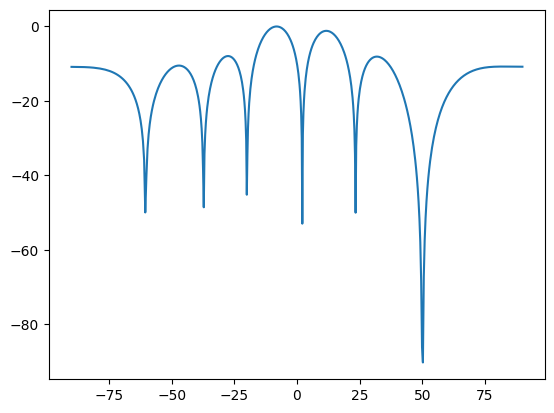

In [6761]:
theta_scan = np.arcsin(np.linspace(-1, 1, N_fft))
plt.plot(theta_scan*180/np.pi, w_fft_dB)
plt.show()

(1, 1000)


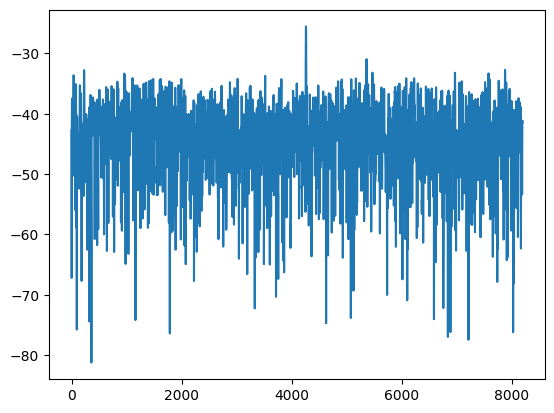

In [6762]:
Y = w @ X #w is already conjugated
print(Y.shape)
plt.plot(10*np.log10(np.abs(np.fft.fft(Y[0],8192))**2))
plt.show()